In [2]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import pickle
import gzip
from tqdm import tqdm_notebook, tqdm
import tensorflow as tf
import keras.backend as K

%matplotlib inline

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
K.set_session(sess)

# Reading dataset

In [5]:
with gzip.open('../cache/dataset.pkl.gz', 'rb') as f:
    X_raw, y_raw = pickle.load(f)

In [6]:
len(X_raw), len(y_raw)

(17, 17)

In [7]:
X_holdout, y_holdout = X_raw[10], y_raw[10] # lavina

In [8]:
X_raw = X_raw[:10] + X_raw[11:]
y_raw = y_raw[:10] + y_raw[11:]

In [9]:
len(X_holdout)

769

In [10]:
pd.Series.value_counts(y_holdout)

2    593
0    145
1     31
dtype: int64

In [11]:
X = []
y = []

for x in X_raw:
    X.extend(x)

for y_ in y_raw:
    y.extend(y_)

In [12]:
len(X), len(y)

(18507, 18507)

# New

In [13]:
from scipy.fftpack import fft
from scipy import signal

In [14]:
sample_rate = 22050

In [15]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# Feature extratction

In [16]:
X = [x if type(x) == type(np.array([])) else np.array(x) for x in X]

In [17]:
X_holdout = [x if type(x) == type(np.array([])) else np.array(x) for x in X_holdout]

In [18]:
len(X)

18507

In [19]:
pd.Series.value_counts([len(x) for x in X])

6615    18506
6318        1
dtype: int64

In [20]:
bad_ind = (np.array([len(x) == 6318 for x in X])).nonzero()[0][0]

In [21]:
bad_ind

1779

In [22]:
X = X[:bad_ind] + X[bad_ind + 1:]
y = y[:bad_ind] + y[bad_ind + 1:]

In [23]:
pd.Series.value_counts([len(x) for x in X])

6615    18506
dtype: int64

In [24]:
def extract_features(x, lim=100, for_cnn=True):
    _, _, spec = log_specgram(x, sample_rate)
    spec = spec[:, :lim]
    if for_cnn:
        spec = np.expand_dims(spec, -1)
    return spec

In [25]:
len(X)

18506

In [26]:
X_spec = []
for x in tqdm(X):
    spec = extract_features(x)
    X_spec.append(spec)
X_spec = np.array(X_spec)

100%|██████████| 18506/18506 [00:09<00:00, 1865.66it/s]


In [27]:
X_spec.shape

(18506, 28, 100, 1)

In [28]:
X_holdout_spec = []
for x in tqdm(X_holdout):
    spec = extract_features(x)
    X_holdout_spec.append(spec)
X_holdout_spec = np.array(X_holdout_spec)

100%|██████████| 769/769 [00:00<00:00, 1466.95it/s]


## Checking mean specs for different audios

In [ ]:
# X_raw_specs = []
# for raw in tqdm(X_raw):
#     specs = []
#     for sample in raw:
#         spec = extract_features(np.array(sample))
#         if spec.shape == (28, 100):
#             specs.append(spec)
#     specs = np.array(specs)
#     X_raw_specs.append(specs)

In [ ]:
# for i in range(len(X_raw_specs)):
# #     print(X_raw_specs[i].shape)
#     print(X_raw_specs[i].mean(), X_raw_specs[i].std())

# Data split

In [43]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [29]:
X_spec.shape

(18506, 28, 100, 1)

In [30]:
X_spec.mean()

-20.350042

In [31]:
X_spec.std()

2.8945801

In [32]:
mean = X_spec.mean()
std = X_spec.std()

In [33]:
X_spec -= mean
X_spec /= std

In [34]:
X_spec.mean(), X_spec.std()

(-6.8040476e-06, 0.9999992)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_spec, y, test_size=0.1,
                                                    stratify=y, random_state=10)

In [107]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,
#                                                     stratify=y_train, random_state=10)

In [38]:
X_val, y_val = X_holdout_spec, y_holdout

In [39]:
X_val -= mean
X_val /= std

In [40]:
X_val.mean(), X_val.std()

(0.35130706, 1.0471298)

In [44]:
y_train, y_val, y_test = to_categorical(y_train), to_categorical(y_val),\
                         to_categorical(y_test)

In [45]:
vc = pd.Series.value_counts(np.argmax(y_train, 1), True)
vc

2    0.838907
0    0.132032
1    0.029060
dtype: float64

In [46]:
vc = pd.Series.value_counts(np.argmax(y_val, 1), True)
vc

2    0.771131
0    0.188557
1    0.040312
dtype: float64

In [48]:
frac = 0.75

In [49]:
vc[2] / vc[0] * frac - 1, vc[2] / vc[1] * frac - 1

(2.067241379310345, 13.346774193548388)

In [50]:
X_train = np.vstack((X_train, np.repeat(X_train[np.argmax(y_train, 1) == 0], 4, 0)))
y_train = np.vstack((y_train, np.repeat(y_train[np.argmax(y_train, 1) == 0], 4, 0)))

In [51]:
X_train = np.vstack((X_train, np.repeat(X_train[np.argmax(y_train, 1) == 1], 20, 0)))
y_train = np.vstack((y_train, np.repeat(y_train[np.argmax(y_train, 1) == 1], 20, 0)))

In [52]:
pd.Series.value_counts(np.argmax(y_train, 1), True)

2    0.397711
0    0.312971
1    0.289317
dtype: float64

---

In [53]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [54]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from keras.layers import GRU, BatchNormalization, Reshape
from keras.utils import to_categorical
from keras.layers import Input, Conv1D, Activation, MaxPool1D
from keras.models import Model

# Rnn model

In [55]:
def create_rnn_model(input_shape):
    x_input = Input(input_shape)
    x = Reshape(input_shape[:-1])(x_input)
#     x = Conv1D(64, 1)(x_input)
#     x = Activation('relu')(x)
    x = Conv1D(128, 3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = GRU(192, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=x_input, outputs=x)
    return model

In [56]:
rnn_model = create_rnn_model(X_train[0].shape)

In [57]:
X_train[0].shape

(28, 100, 1)

In [58]:
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 100, 1)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 128)           38528     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 128)           512       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 26, 128)           98688     
__________

In [59]:
rnn_model.compile('adam', 'categorical_crossentropy')

In [61]:
rnn_model.get_weights()[0].shape

(3, 100, 128)

## Training

In [62]:
pd.Series.value_counts(np.argmax(y_test, 1), True)

2    0.839006
0    0.131821
1    0.029173
dtype: float64

In [63]:
def schedule(i, lr):
    if i == 0:
        lr *= 0.5
    if i == 5:
        lr *= 0.2
    if i == 10:
        lr *= 0.2
    return lr

In [64]:
hist = rnn_model.fit(X_train, y_train, batch_size=128, epochs=10,
#                  class_weight={0: 3, 1: 5, 2: 1},
                 validation_data=(X_test, y_test), # val
                 callbacks=[keras.callbacks.LearningRateScheduler(schedule, verbose=1)])

Train on 35131 samples, validate on 1851 samples
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 24s 695us/step - loss: 0.5890 - val_loss: 0.7326
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 23s 655us/step - loss: 0.3152 - val_loss: 0.6739
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 23s 647us/step - loss: 0.2285 - val_loss: 0.4092
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 23s 656us/step - loss: 0.1817 - val_loss: 0.3826
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 23s 659us/step - loss: 0.1499 - val_loss

In [66]:
pr = rnn_model.predict(X_val, batch_size=128, verbose=1)

769/769 [==============================] - 0s 259us/step


In [67]:
pr = pr.argmax(1)

In [68]:
pd.Series.value_counts(pr)

2    554
0    184
1     31
dtype: int64

In [69]:
accuracy_score(np.argmax(y_val, 1), pr)

0.8894668400520156

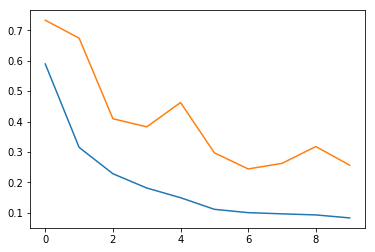

In [70]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')

In [71]:
print(classification_report(np.argmax(y_val, 1), pr))

             precision    recall  f1-score   support

          0       0.73      0.92      0.81       145
          1       0.61      0.61      0.61        31
          2       0.96      0.90      0.93       593

avg / total       0.90      0.89      0.89       769



---

In [72]:
pr = rnn_model.predict(X_test, batch_size=128, verbose=1)

1851/1851 [==============================] - 0s 203us/step


In [73]:
pr = pr.argmax(1)

In [74]:
accuracy_score(np.argmax(y_test, 1), pr)

0.9303079416531604

In [75]:
print(classification_report(np.argmax(y_test, 1), pr))

             precision    recall  f1-score   support

          0       0.84      0.97      0.90       244
          1       0.40      0.89      0.55        54
          2       0.99      0.93      0.96      1553

avg / total       0.95      0.93      0.94      1851



---

In [77]:
%timeit rnn_model.predict(X_val[:1, :, :])

20.9 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Saving

In [78]:
rnn_model.save('../cache/rnn_model.h5')

In [79]:
rnn_model_json = rnn_model.to_json()

In [80]:
with open('../cache/rnn_model.json', 'w') as f:
    f.write(rnn_model_json)

In [81]:
rnn_model.save_weights('../cache/rnn_model_weights.h5')

# Cnn model

In [82]:
def create_cnn_model(input_shape):
    x_input = Input(input_shape)
    x = Conv2D(16, 3, activation='relu', padding='same')(x_input)
    x = Conv2D(16, 3, activation='relu', padding='same')(x)
    x = MaxPool2D((2, 3))(x)
    
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPool2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPool2D()(x)
    
    x = Conv2D(128, 3, activation='relu')(x)
    x = Conv2D(128, (1, 6), activation='relu')(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=x)
    return model

In [83]:
cnn_model = create_cnn_model(X_train[0].shape)

In [84]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 100, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 100, 16)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 100, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 33, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 33, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 33, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 16, 32)         0         
__________

In [85]:
X_train[0].shape

(28, 100, 1)

In [86]:
cnn_model.compile('adam', 'categorical_crossentropy')

## Training

In [87]:
# def schedule(i, lr):
#     if i == 0:
#         lr *= 0.5
#     if i == 5:
#         lr *= 0.2
#     if i == 10:
#         lr *= 0.2
#     return lr

In [88]:
def schedule(i, lr):
    if i == 0:
        lr *= 0.5
    if i == 5:
        lr *= 0.2
    if i == 10:
        lr *= 0.2
    return lr

In [89]:
hist = cnn_model.fit(X_train, y_train, batch_size=128, epochs=7,
#                  class_weight={0: 3, 1: 5, 2: 1},
                 validation_data=(X_test, y_test), # val
                 callbacks=[keras.callbacks.LearningRateScheduler(schedule, verbose=1)])

Train on 35131 samples, validate on 1851 samples
Epoch 1/7

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 5s 130us/step - loss: 0.4940 - val_loss: 0.2785
Epoch 2/7

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 4s 115us/step - loss: 0.2157 - val_loss: 0.1826
Epoch 3/7

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 4s 115us/step - loss: 0.1276 - val_loss: 0.2556
Epoch 4/7

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 4s 116us/step - loss: 0.0972 - val_loss: 0.2067
Epoch 5/7

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 4s 114us/step - loss: 0.0664 - val_loss: 0.2348
E

In [90]:
pr = cnn_model.predict(X_val, batch_size=128, verbose=1)

769/769 [==============================] - 0s 294us/step


In [91]:
pr = pr.argmax(1)

In [92]:
pd.Series.value_counts(pr)

2    587
0    152
1     30
dtype: int64

In [93]:
accuracy_score(np.argmax(y_val, 1), pr)

0.929778933680104

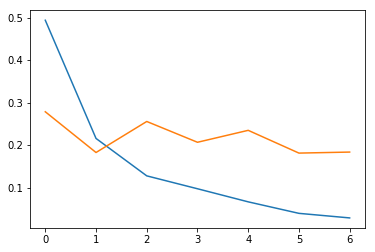

In [94]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')

In [95]:
print(classification_report(np.argmax(y_val, 1), pr))

             precision    recall  f1-score   support

          0       0.86      0.90      0.88       145
          1       0.70      0.68      0.69        31
          2       0.96      0.95      0.96       593

avg / total       0.93      0.93      0.93       769



---

In [96]:
pr = cnn_model.predict(X_test, batch_size=128, verbose=1)

1851/1851 [==============================] - 0s 43us/step


In [97]:
pr = pr.argmax(1)

In [98]:
accuracy_score(np.argmax(y_test, 1), pr)

0.95569962182604

In [99]:
print(classification_report(np.argmax(y_test, 1), pr))

             precision    recall  f1-score   support

          0       0.89      0.96      0.92       244
          1       0.60      0.65      0.62        54
          2       0.98      0.97      0.97      1553

avg / total       0.96      0.96      0.96      1851



---

In [100]:
%timeit cnn_model.predict(X_val[:1, :, :])

1.88 ms ± 88.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Saving

In [101]:
cnn_model.save('../cache/cnn_model.h5')

In [102]:
cnn_model_json = cnn_model.to_json()

In [103]:
with open('../cache/cnn_model.json', 'w') as f:
    f.write(cnn_model_json)

In [104]:
cnn_model.save_weights('../cache/cnn_model_weights.h5')

# Twin model

In [328]:
from keras.utils import plot_model
from keras.layers import concatenate

In [329]:
plot_model(cnn_model, '../cache/cnn_model.png', show_shapes=True)

In [330]:
plot_model(rnn_model, '../cache/rnn_model.png', show_shapes=True)

In [343]:
def create_twin_model(input_shape):
    x_input = Input(input_shape)
    
    # Cnn part
    c = Conv2D(16, 3, activation='relu', padding='same')(x_input)
    c = Conv2D(16, 3, activation='relu', padding='same')(c)
    c = MaxPool2D((2, 3))(c)
    
    c = Conv2D(16, 3, activation='relu', padding='same')(c)
    c = Conv2D(32, 3, activation='relu', padding='same')(c)
    c = MaxPool2D()(c)

    c = Conv2D(32, 3, activation='relu', padding='same')(c)
    c = Conv2D(64, 3, activation='relu', padding='same')(c)
    c = MaxPool2D()(c)
    
    c = Conv2D(64, 3, activation='relu')(c)
    c = Conv2D(128, (1, 6), activation='relu')(c)
#     c = Flatten()(c)
    c = Reshape((int(c.shape[-1:][0]),))(c)
    c = Dropout(0.5)(c)
    
    # Rnn part
    r = Reshape(input_shape[:-1])(x_input)
    r = Conv1D(96, 3)(r)
    r = BatchNormalization()(r)
    r = Activation('relu')(r)
    r = Dropout(0.5)(r)
    
    r = GRU(96, return_sequences=True)(r)
    r = Dropout(0.5)(r)
    r = BatchNormalization()(r)
    
    r = GRU(64, return_sequences=False)(r)
    r = Dropout(0.5)(r)
    r = BatchNormalization()(r)
    
    x = concatenate([c, r])
    x = Dense(64, activation='relu')(x)
    x = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=x_input, outputs=x)
    return model

In [344]:
twin_model = create_twin_model(X_train[0].shape)

In [345]:
twin_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 28, 100, 1)   0                                            
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 28, 100, 16)  160         input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_143 (Conv2D)             (None, 28, 100, 16)  2320        conv2d_142[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_55 (MaxPooling2D) (None, 14, 33, 16)   0           conv2d_143[0][0]                 
__________________________________________________________________________________________________
reshape_36

In [346]:
plot_model(twin_model, '../cache/twin_model.png', show_shapes=True)

In [347]:
twin_model.compile('adam', 'categorical_crossentropy')

## Training

In [348]:
def schedule(i, lr):
    if i == 0:
        lr *= 0.5
    if i == 5:
        lr *= 0.2
    if i == 10:
        lr *= 0.2
    return lr

In [349]:
hist = twin_model.fit(X_train, y_train, batch_size=128, epochs=8,
#                  class_weight={0: 3, 1: 5, 2: 1},
                 validation_data=(X_test, y_test), # val
                 callbacks=[keras.callbacks.LearningRateScheduler(schedule, verbose=1)])

Train on 35131 samples, validate on 1851 samples
Epoch 1/8

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 33s 931us/step - loss: 0.4911 - val_loss: 0.6150
Epoch 2/8

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 25s 708us/step - loss: 0.2193 - val_loss: 0.3375
Epoch 3/8

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 25s 707us/step - loss: 0.1478 - val_loss: 0.2249
Epoch 4/8

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 25s 703us/step - loss: 0.1060 - val_loss: 0.2261
Epoch 5/8

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
35131/35131 [==============================] - 25s 704us/step - loss: 0.0860 - val_loss: 0.2

In [350]:
pr = twin_model.predict(X_val, batch_size=128, verbose=1)

769/769 [==============================] - 2s 3ms/step


In [351]:
pr = pr.argmax(1)

In [352]:
pd.Series.value_counts(pr)

2    573
0    168
1     28
dtype: int64

In [353]:
accuracy_score(np.argmax(y_val, 1), pr)

0.9258777633289987

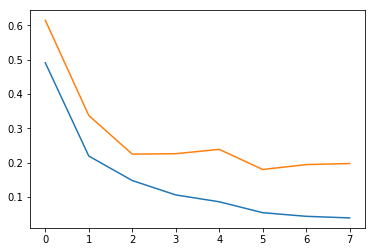

In [354]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')

In [355]:
print(classification_report(np.argmax(y_val, 1), pr))

             precision    recall  f1-score   support

          0       0.82      0.95      0.88       145
          1       0.68      0.61      0.64        31
          2       0.97      0.94      0.95       593

avg / total       0.93      0.93      0.93       769



---

In [356]:
pr = twin_model.predict(X_test, batch_size=128, verbose=1)

1851/1851 [==============================] - 0s 208us/step


In [357]:
pr = pr.argmax(1)

In [358]:
accuracy_score(np.argmax(y_test, 1), pr)

0.9535386277687736

In [359]:
print(classification_report(np.argmax(y_test, 1), pr))

             precision    recall  f1-score   support

          0       0.87      0.98      0.92       244
          1       0.56      0.74      0.64        54
          2       0.99      0.96      0.97      1553

avg / total       0.96      0.95      0.96      1851



---

In [360]:
%timeit twin_model.predict(X_val[:1, :, :])

22.7 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Saving

In [361]:
twin_model.save('../cache/twin_model.h5')

In [362]:
twin_model_json = twin_model.to_json()

In [363]:
with open('../cache/twin_model.json', 'w') as f:
    f.write(twin_model_json)

In [364]:
twin_model.save_weights('../cache/twin_model_weights.h5')

# Testing on new data

In [345]:
def get_praat_annotations(paths):
    dfs = []
    for path in paths:
        with open(path) as f:
            annotation = [l.strip() for l in f.readlines()]
            
        indxs = [i for i, l in enumerate(annotation) if l == '"IntervalTier"']
        annotation = annotation[indxs[0] + 5:indxs[1] if len(indxs) > 1\
                                else len(annotation)]
        annotation_dicts = []

        for s, e, l in zip(annotation[0::3], annotation[1::3], annotation[2::3]):
            annotation_dicts.append({
                'start': float(s),
                'finish': float(e),
                'label': l.replace('"', ''),
                'length': float(e) - float(s)
            })
        df = pd.DataFrame(annotation_dicts)
        dfs.append(df)
    return dfs

test_annotation = get_praat_annotations(['../annotations/lavina_class.TextGrid'])

In [346]:
test_audio, sr = librosa.load('../audio/lavina_class.m4a')

In [347]:
interval_time = 0.3
interval_step = 0.1

interval_len, step_len = librosa.time_to_samples(interval_time), \
                 librosa.time_to_samples(interval_step) #[0]

In [348]:
interval_len, step_len

(6615, 2205)

In [349]:
test_annotation[0][test_annotation[0].label == 'a'].length.describe()

count    53.000000
mean      0.352322
std       0.106933
min       0.190203
25%       0.297984
50%       0.355045
75%       0.393086
max       0.798852
Name: length, dtype: float64

In [350]:
librosa.time_to_samples(0.18)

3969

In [351]:
def get_intersection_of_intervals(a, b):
    # a - fixed, b - random, a[0] - x1, a[1] - y1
    int_len = a[1] - a[0]
    
    if b[1] > a[0]:
        right_int = max(a[1] - b[1], 0)
    else:
        right_int = int_len
    
    if b[0] < a[1]:
        left_int = max(b[0] - a[0], 0)
    else:
        left_int = int_len
    return int_len - right_int - left_int

In [352]:
len(test_audio)

8609276

In [353]:
min_delta = interval_len // 3

In [354]:
min_delta

2205

In [355]:
def match_intervals(annotation, audio, labels, sr=22050):
    audio_intervals = [(x, x + interval_len) for x in range(0, len(audio), step_len)][:-4]
    targets = []
    values = []
    label_map = {'a': 0, 'b': 1, 'c': 2}
    for interval in audio_intervals:
        value = 0
        for label in labels:
            l = label_map[label]
            start_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                                  label].start.values, sr)
            finish_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                                   label].finish.values,
                                                                   sr)
            for s, f in zip(start_samples_indxs, finish_samples_indxs):
                value = get_intersection_of_intervals(interval, (s, f))
                if value > min_delta:
                    break
                else:
                    value = 0
            if value != 0:
                break
        if value != 0:
            targets.append(l)
        else:
            targets.append(2)
        values.append(value)
    return audio_intervals, targets, values

Идем с шагом step_len и берем интервалы по interval_len, проверяем - с каким из размеченных интервалов пересекается наш интервал больше чем на min_delta и присваиваем его метку

Не учитываются случаи, когда идет несколько подряд "эээ" и "нуу", и так как метки отсортированы, пока интервал будет касаться левой стороной первого "эээ", а правой "нуу", то будет присвоена метка "эээ". **TODO**

In [356]:
%%time
test_intervals, test_targets, vals = match_intervals(test_annotation[0], test_audio,
                                                     ['a', 'b'])

CPU times: user 9.78 s, sys: 73.7 ms, total: 9.85 s
Wall time: 9.69 s


In [357]:
len(test_intervals), len(test_targets)

(3901, 3901)

In [358]:
pd.Series.value_counts(test_targets)

2    3604
0     239
1      58
dtype: int64

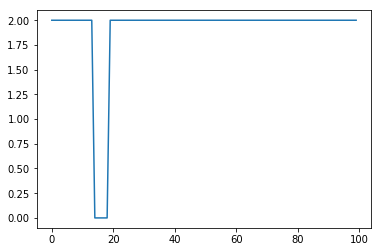

In [359]:
plt.plot(test_targets[:100])

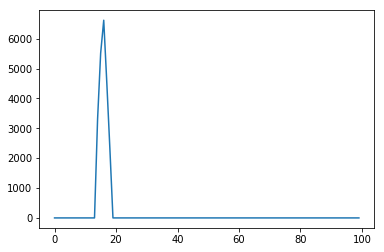

In [360]:
plt.plot(vals[:100])

In [361]:
len(test_audio)

8609276

In [362]:
test_samples = [test_audio[s:f] for s, f in test_intervals]

### Checking intervals

In [364]:
test_features = np.stack([extract_features(x) for x in tqdm(test_samples)])

100%|██████████| 3901/3901 [00:02<00:00, 1483.93it/s]


In [365]:
test_features.shape

(3901, 28, 100, 1)

TODO: нормальная нормальзация

-20.350365, 2.89434

In [367]:
test_features -= mean
test_features /= std

In [ ]:
# test_features -= min_spec
# test_features /= (max_spec - min_spec)

In [393]:
test_predict_cnn = cnn_model.predict(test_features, batch_size=128).argmax(1)

In [370]:
test_predict_rnn = rnn_model.predict(test_features, batch_size=128).argmax(1)

In [371]:
test_predict_twin = twin_model.predict(test_features, batch_size=128).argmax(1)

In [372]:
# test_predict_pr = model.predict(test_features, batch_size=32)

**TODO** сделать усреднение предикта с 1 влево 1 вправо интервалами

In [394]:
accuracy_score(test_targets, test_predict_cnn)

0.9271981543194053

In [374]:
accuracy_score(test_targets, test_predict_rnn)

0.8843886183029992

In [375]:
accuracy_score(test_targets, test_predict_twin)

0.9107921045885671

In [377]:
accuracy_score(test_targets, [2] * len(test_predict_rnn))

0.9238656754678287

In [395]:
print(classification_report(test_targets, test_predict_cnn))

             precision    recall  f1-score   support

          0       0.53      0.53      0.53       239
          1       0.48      0.21      0.29        58
          2       0.96      0.97      0.96      3604

avg / total       0.92      0.93      0.92      3901



In [379]:
print(classification_report(test_targets, test_predict_rnn))

             precision    recall  f1-score   support

          0       0.33      0.60      0.43       239
          1       0.38      0.19      0.25        58
          2       0.96      0.91      0.94      3604

avg / total       0.91      0.88      0.89      3901



In [380]:
print(classification_report(test_targets, test_predict_twin))

             precision    recall  f1-score   support

          0       0.43      0.54      0.48       239
          1       0.32      0.21      0.25        58
          2       0.96      0.95      0.95      3604

avg / total       0.92      0.91      0.91      3901



---

In [ ]:
plt.plot(test_predict[:2000], '--', label='pr', alpha=0.4)
plt.plot(test_targets[:2000], '-.', label='tr', alpha=0.4)
plt.legend()

## Sliding window

In [ ]:
test_predict_mean = np.stack(((np.pad(test_predict_pr[1:, 0], (0, 1), 'edge') + \
                    test_predict_pr[:, 0] + \
    np.pad(test_predict_pr[:-1, 0], (1, 0), 'edge')) / 3,
          (np.pad(test_predict_pr[1:, 1], (0, 1), 'edge') + test_predict_pr[:, 1] + \
    np.pad(test_predict_pr[:-1, 1], (1, 0), 'edge')) / 3,
          (np.pad(test_predict_pr[1:, 2], (0, 1), 'edge') + test_predict_pr[:, 2] + \
    np.pad(test_predict_pr[:-1, 2], (1, 0), 'edge')) / 3), axis=1)

In [ ]:
test_predict_mean.shape

In [ ]:
lim = 100

In [ ]:
plt.plot(test_predict[:lim])

In [ ]:
plt.plot(test_predict_pr[:lim, 0], label='0')
plt.plot(test_predict_pr[:lim, 1], label='1')
plt.plot(test_predict_pr[:lim, 2], label='2')
plt.legend()

In [ ]:
plt.plot(test_predict_mean[:lim, 0], label='0')
plt.plot(test_predict_mean[:lim, 1], label='1')
plt.plot(test_predict_mean[:lim, 2], label='2')
plt.legend()

In [ ]:
test_predict_mean[:, 2]

In [ ]:
test_predict_pr[:, 2]

In [ ]:
print(classification_report(test_targets, test_predict_pr.argmax(1)))

In [ ]:
print(classification_report(test_targets, test_predict_mean.argmax(1)))

In [ ]:
confusion_matrix(test_targets, test_predict_pr.argmax(1))

In [ ]:
confusion_matrix(test_targets, test_predict_mean.argmax(1))

## Errors analysis

In [ ]:
e = np.nonzero((test_targets != test_predict_pr.argmax(1)) & \
               (test_predict_pr.argmax(1) == 0))[0]

wids = [Audio(test_samples[i], rate=22050) for i in e[:5]]
for w in wids:
    display(w)

In [ ]:
e = np.nonzero((test_targets != test_predict_pr.argmax(1)) & \
               (test_predict_pr.argmax(1) == 1))[0]

wids = [Audio(test_samples[i], rate=22050) for i in e[:5]]
for w in wids:
    display(w)

In [ ]:
e = np.nonzero((test_targets != test_predict_pr.argmax(1)) & \
               (test_predict_pr.argmax(1) == 2))[0]

wids = [Audio(test_samples[i], rate=22050) for i in e[:5]]
for w in wids:
    display(w)

## Отображение результата

In [ ]:
from PIL import Image
import os
import shutil

In [ ]:
# os.rmdir('../cache/imgs/')
shutil.rmtree('../cache/imgs/')

In [ ]:
os.mkdir('../cache/imgs')

In [ ]:
1 / interval_step

In [ ]:
interval_step

In [ ]:
for i, (r, t) in enumerate(zip(test_predict_mean.argmax(1), test_targets)):
    im_r = np.zeros((32, 64, 3), dtype='uint8')
    if r == 0:
        im_r[:,:,0] = 255
    elif r == 2:
        im_r[...,2] = 255
    else:
        im_r[...,1] = 255
        
    im_t = np.zeros((32, 64, 3), dtype='uint8')
    if t == 0:
        im_t[:,:,0] = 255
    elif t == 2:
        im_t[...,2] = 255
    else:
        im_t[...,1] = 255
        
    im = np.vstack((im_r, im_t))
    im = Image.fromarray(im)
    im.save('../cache/imgs/test_{:04d}.png'.format(i + 2))
im.save('../cache/imgs/test_{:04d}.png'.format(0))
im.save('../cache/imgs/test_{:04d}.png'.format(1))

In [ ]:
os.system('ffmpeg -r 10 -i ../cache/imgs/test_%04d.png -i ../audio/lavina_class.m4a -vcodec mpeg4 -y ../cache/a.mp4')

## Ручная корректировка шума

In [ ]:
test_predict_new = test_predict_new.ravel()

In [ ]:
%%time
test_predict_new2 = []

start = False
for t, tn in zip(test_predict_new, np.append(test_predict_new[1:], [1])):
    if t == 0 and tn == 0 and not start:
        # если встретили 0 и следующий 0 и до этого не началось, включаем начало и доб-ем 0
        start = True
        test_predict_new2.append(0)
    elif t == 0 and tn == 0 and start:
        # если встретили 0 и следующий 0 и до этого началось, доб-ем 0 - мы в серии нулей
        test_predict_new2.append(0)
    elif t == 0 and tn != 0 and not start:
        # если встретили 0, а следующий не 0 и до этого не началось, значит шум, не 0 
        test_predict_new2.append(1)
    elif t == 0 and tn != 0 and start:
        # если встретили 0, а след. не 0 и до этого началось, значит 0, но начало в False
        start = False
        test_predict_new2.append(0)
    elif t == 1:
        # если встрили 1, добавляем 1
        test_predict_new2.append(1)
        start = False
    else:
        print(t, tn, start)

In [ ]:
pd.Series.value_counts(test_predict_new)

In [ ]:
pd.Series.value_counts(test_predict_new2)

In [ ]:
print(classification_report(test_data.values, test_predict_new))

In [ ]:
print(classification_report(test_data.values, test_predict_new2))

Precision поднялся на 0.07, а recall упал лишь на 0.01

## Отображение результата

In [ ]:
shutil.rmtree('../cache/imgs/')

In [ ]:
os.mkdir('../cache/imgs')

In [ ]:
for i, (r, t) in enumerate(zip(test_predict_new2, test_data.values)):
    im_r = np.zeros((32, 64, 3), dtype='uint8')
    if r == 0:
        im_r[:,:,0] = 255
    elif r == 1:
        im_r[...,2] = 255
    else:
        im_r[...,1] = 255
        
    im_t = np.zeros((32, 64, 3), dtype='uint8')
    if t == 0:
        im_t[:,:,0] = 255
    elif t == 1:
        im_t[...,2] = 255
    else:
        im_t[...,1] = 255
        
    im = np.vstack((im_r, im_t))
    im = Image.fromarray(im)
    im.save('../cache/imgs/test_{:04d}.png'.format(i + 2))
im.save('../cache/imgs/test_{:04d}.png'.format(0))
im.save('../cache/imgs/test_{:04d}.png'.format(1))

In [ ]:
os.system('ffmpeg -r 20 -i ../cache/imgs/test_%04d.png -i ../audio/arhis1.mp3 -vcodec mpeg4 -y ../cache/aa.mp4')